This notebook explores **time series modeling of neural data** collected from the primary motor cortex of a monkey during movement tasks. It covers train/test split, representing time-series information, and fitting both memoryless and time-delayed linear models. The notebook demonstrates model order selection by using cross-validation to determine the optimal delay for the time-series models. It also includes visualizations and performance comparisons between models to understand how neural signals encode movement patterns.

Import modules and Load the data

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from six.moves import urllib

In [27]:
fn_src = 'https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true'
fn_dst = 'example_data_s1.pickle'

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


In [28]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

y = y[:,0]


In [29]:
# calc total time represented by data 
tsamp = 0.05  # sampling time in seconds
nt = X.shape[0] 
nneuron = X.shape[1]
ttotal = nt*tsamp

Split the data into training and testing sets

In [30]:
shuffled = np.random.permutation(nt) #shuffled row nums
split = int(nt*(2/3)) #split index

#create index arrays for which indices (rows) are in train, which are in test
trInd = shuffled[:split] 
tsInd = shuffled[split:]

#create train and test sets using those indices
Xtr = X[trInd,:]
ytr = y[trInd]
Xts = X[tsInd,:]
yts = y[tsInd]

Fit a memoryless multi-linear regression model using the closed form solution for optimizing l2 loss

In [31]:
#multiple linear regression optimization function
def fit_mult_linear(X,y):
    X_orig = X
    size = X.shape[0]
    ones = np.ones((size,1)) #add a column of ones to X
    X = np.hstack((ones,X_orig))
    Xt = np.transpose(X)
    beta = np.linalg.inv(Xt @ X) @ Xt @ y #closed form equation
    
    return beta

In [32]:
#add ones col to test set
XtsSize = Xts.shape[0]
ones = np.ones((XtsSize,1))
Xts = np.hstack((ones,Xts))

In [33]:
#fit the model on the training data
beta = fit_mult_linear(Xtr,ytr)
yhat = Xts @ beta

In [34]:
#add a column of ones to Xts
XtsSize = Xts.shape[0]
ones = np.ones((XtsSize,1))
Xts = np.hstack((ones,Xts))

In [35]:
# find test loss
loss = (yhat-yts)**2
er = np.sum(loss)/Xts.shape[0]
print(er)

31.953519904012136


visualize model predicted values vs true values for the test set 

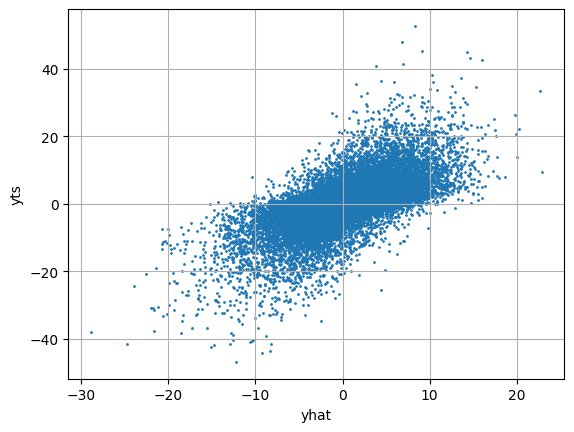

In [36]:
plt.scatter(yhat,yts, s=1)
plt.xlabel('yhat')
plt.ylabel('yts')
plt.grid(True)

Fit a model with delay to improve the model's accuracy in predicting the neural data

In [37]:
#function to create a delayed data matrix with a specified delay
def create_dly_data(X,y,d): #d is the number of delay steps 
    Xdly = []
    ydly = []
    rows, cols = X.shape
    
    for i in range(rows - d):
        currRow = []
        for j in range(cols):
            currRow.extend(X[i:i+d+1,j])
        Xdly.append(currRow)
        ydly.append(y[i+d])
        
    Xdly = np.array(Xdly)
    ydly = np.array(ydly)

    return Xdly, ydly

In [38]:
#fit a model with delay of 6
Xdly,ydly = create_dly_data(X,y,6)

rows = Xdly.shape[0]
shuffled = np.random.permutation(rows) #shuffled row nums
split = int(rows*(2/3)) #split index

#create index arrays for which indices (rows) are in train, which are in test
trInd = shuffled[:split] 
tsInd = shuffled[split:]

#create train and test sets using those indices
XdlyTr = Xdly[trInd,:]
ydlyTr = ydly[trInd]
XdlyTs = Xdly[tsInd,:]
ydlyTs = ydly[tsInd]

#fit the model
beta = fit_mult_linear(XdlyTr,ydlyTr)

In [39]:
#add ones col to test set
XdlyTsSize = XdlyTs.shape[0]
ones = np.ones((XdlyTsSize,1))
XdlyTs = np.hstack((ones,XdlyTs))

In [40]:
#predict on test set and measure loss - note higher accuracy than memoryless model
yhat = XdlyTs @ beta

loss = (yhat-ydlyTs)**2
er = np.sum(loss)/XdlyTs.shape[0]
print(er)

17.51400967017534


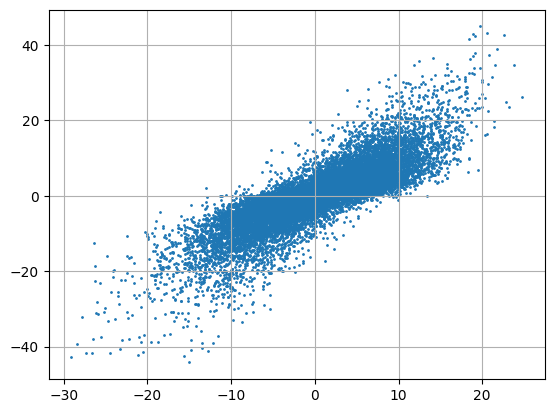

In [41]:
#plot predicted vs true values
plt.scatter(yhat,ydlyTs, s=1)
plt.grid(True)

Cross-validation to determine the optimal delay for the time-series model. Using only one delay matrix to calculating loss given delay from 1 to 30 time steps, which significantly increases code efficiency. 

In [42]:
#create train/test sets for the delay matrix with delay = 30, the max delay we will consider.
#each row has all of the steps we will need to test the model with delays from 1 to 30

dmax = 30

Xdly, ydly = create_dly_data(X,y,dmax)

#shuffle rows and split index
rows = Xdly.shape[0]
shuffled = np.random.permutation(rows) 
split = int(rows*(2/3)) 

#create index arrays for which indices (rows) are in train, which are in test
trInd = shuffled[:split] 
tsInd = shuffled[split:]

#create train and test sets using those indices
XdlyTr = Xdly[trInd,:]
ydlyTr = ydly[trInd]
XdlyTs = Xdly[tsInd,:]
ydlyTs = ydly[tsInd]

In [48]:
#loop through delays from 1 to 30, fit the model, and calculate loss. print loss for each delay
losses = np.zeros(dmax)

atts = X.shape[1]

#iterate through each delay value from 0-dmax
for i in range(dmax):
    XcurrTr = np.empty((XdlyTr.shape[0], 0))  
    XcurrTs = np.empty((XdlyTs.shape[0], 0))
    
    #iterate through each attribute to append delay columns for current delay
    for j in range(1,atts):
        
        endInd = (j + 1) * (dmax + 1)
        startInd = endInd - (i + 1)
        
        tempTr = XdlyTr[:, startInd:endInd]
        tempTs = XdlyTs[:, startInd:endInd]
            
        XcurrTr = np.hstack((XcurrTr, tempTr))  
        XcurrTs = np.hstack((XcurrTs, tempTs))
        
    #calculate beta vector from training set
    beta = fit_mult_linear(XcurrTr,ydlyTr)
    
    #add ones column to training set
    tempShape = XcurrTs.shape[0]
    ones = np.ones((tempShape,1))
    XcurrTs = np.hstack((ones,XcurrTs))
    
    #get predicted values based on current delay/beta vector
    yhat = XcurrTs @ beta
    
    #measure risk/loss and add to losses array
    loss = (yhat-ydlyTs)**2
    er = np.sum(loss)/XdlyTs.shape[0]
    losses[i] = er

print(losses)

[31.96351019 25.07929496 21.97604581 20.15518183 18.96503    18.13015912
 17.51056988 16.97591062 16.66076244 16.44872908 16.33103792 16.28915858
 16.24416822 16.22719735 16.18656531 16.15901552 16.1446948  16.12255628
 16.13054571 16.13360991 16.15843532 16.19719628 16.20752592 16.2328195
 16.26857906 16.27900181 16.30396052 16.32947234 16.33470071 16.35527838]


best delay = 18


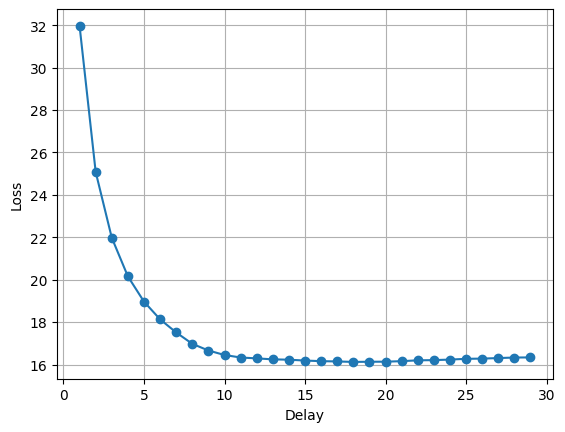

In [49]:
#plot delay vs loss and print the delay that minimizes loss

#find index with lowest risk
best_delay = np.argmin(losses) + 1
print("best delay = " + str(best_delay))

#plot risk for each delay 0 - dmax
dRange = np.arange(1,dmax)
plt.plot(dRange, losses[0:dmax-1], 'o-')
plt.xlabel('Delay')
plt.ylabel('Loss')
plt.grid(True)
plt.show()